In [ ]:
# default_exp data.tsdataset

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import time
import gc
import logging
import random
from collections import defaultdict
from typing import Collection, Dict, Iterable, List, Optional, Tuple
from typing_extensions import Literal

import numpy as np
import pandas as pd
import torch as t
from fastcore.foundation import patch

from torch.utils.data import Dataset, DataLoader

In [ ]:
#export
# TODO: paralelizar y mejorar _df_to_lists, probablemente Pool de multiprocessing
#.      si está balanceado el panel np reshape hace el truco <- pensar
# TODO: definir defaults para sample_mask, calculo de availabitly al interior con ds
# TODO: define future of f_cols.
class TimeSeriesDataset(Dataset):
    def __init__(self,
                 Y_df: pd.DataFrame,
                 X_df: pd.DataFrame = None,
                 S_df: pd.DataFrame = None,
                 mask_df: Optional[pd.DataFrame] = None,
                 ds_in_test: int = 0,
                 is_test: bool = False,
                 f_cols: Optional[list] = None,
                 verbose: bool = False) -> 'TimeSeriesDataset':
        """
        TimeSeriesDataset.
        
        Parameters
        ----------
        Y_df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        X_df: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds'] 
            and static variables.
        mask_df: pd.DataFrame
            Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
            and optionally 'available_mask'.
            Default None: constructs default mask based on ds_in_test.
        ds_in_test: int
            Only used when mask_df = None.
            Numer of datestamps to use as outsample.
        is_test: bool
            Only used when mask_df = None.
            Wheter target time series belongs to test set.
        verbose: bool
            Wheter log outputs.
        """
        assert type(Y_df) == pd.core.frame.DataFrame
        assert all([(col in Y_df) for col in ['unique_id', 'ds']])
        self.verbose = verbose

        if X_df is not None:
            assert type(X_df) == pd.core.frame.DataFrame
            assert all([(col in X_df) for col in ['unique_id', 'ds']])
            assert len(Y_df)==len(X_df), f'The dimensions of Y_df and X_df are not the same'

        if mask_df is not None:
            assert len(Y_df)==len(mask_df), f'The dimensions of Y_df and mask_df are not the same'
            assert all([(col in mask_df) for col in ['unique_id', 'ds', 'sample_mask']])
            if 'available_mask' not in mask_df.columns:
                self.verbose: logging.info('Available mask not provided, defaulted with 1s.')
                mask_df['available_mask'] = 1
            assert np.sum(np.isnan(mask_df.available_mask.values)) == 0
            assert np.sum(np.isnan(mask_df.sample_mask.values)) == 0
        else:
            mask_df = self.get_default_mask_df(Y_df=Y_df, 
                                               is_test=is_test,
                                               ds_in_test=ds_in_test)
        
        # Logging
        #start = time.time()
        mask_df['train_mask'] = mask_df['available_mask'] * mask_df['sample_mask']
        n_ds  = len(mask_df)
        n_avl = mask_df.available_mask.sum()        
        n_ins = mask_df.sample_mask.sum()
        n_out = len(mask_df)-mask_df.sample_mask.sum()

        avl_prc = np.round((100*n_avl)/n_ds,2)
        ins_prc = np.round((100*n_ins)/n_ds,2)
        out_prc = np.round((100*n_out)/n_ds,2)
        if self.verbose:
            logging.info('Train Validation splits\n')
            if len(mask_df.unique_id.unique()) < 10:
                logging.info(mask_df.groupby(['unique_id', 'sample_mask']).agg({'ds': ['min', 'max']}))
            else:
                logging.info(mask_df.groupby(['sample_mask']).agg({'ds': ['min', 'max']}))
            dataset_info  = f'\nTotal data \t\t\t{n_ds} time stamps \n'
            dataset_info += f'Available percentage={avl_prc}, \t{n_avl} time stamps \n'
            dataset_info += f'Insample  percentage={ins_prc}, \t{n_ins} time stamps \n'
            dataset_info += f'Outsample percentage={out_prc}, \t{n_out} time stamps \n'
            logging.info(dataset_info)
        #print(f"logging time {time.time()-start}")

        #start = time.time()
        ts_data, s_data, self.meta_data, self.y_cols, self.t_cols, self.s_cols \
                                            = self._df_to_lists(Y_df=Y_df, S_df=S_df, X_df=X_df, mask_df=mask_df)
        #print(f"df2list time {time.time()-start}")

        # Dataset attributes
        self.n_y        = len(self.y_cols)
        self.n_series   = len(ts_data)
        self.max_len    = max([len(ts) for ts in ts_data])
        self.n_channels = len(self.t_cols) # t_cols insample_mask and outsample_mask
        self.frequency  = pd.infer_freq(Y_df.head()['ds']) #TODO: improve, can die with head
        self.f_cols     = f_cols

        # Number of X and S features
        self.n_x = 0 if X_df is None else X_df.shape[1]-2 # -2 for unique_id and ds
        self.n_s = 0 if S_df is None else S_df.shape[1]-1 # -1 for unique_id

        # print('Creating ts tensor ...')
        # Balances panel and creates 
        # numpy  s_matrix of shape (n_series, n_s)
        # numpy ts_tensor of shape (n_series, n_channels, max_len) n_channels = t_cols + masks
        self.ts_tensor, self.s_matrix, self.len_series = self._create_tensor(ts_data, s_data)

In [ ]:
#export
@patch
def get_default_mask_df(self: TimeSeriesDataset, 
                        Y_df: pd.DataFrame, 
                        ds_in_test: int, 
                        is_test: bool) -> pd.DataFrame:
    """
    Constructs default mask df.

    Parameters
    ----------
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    ds_in_test: int
        Numer of datestamps to use as outsample.
    is_test: bool
        Wheter target time series belongs to test set.

    Returns
    -------
    Mask DataFrame with columns 
    ['unique_id', 'ds', 'available_mask', 'sample_mask'].
    """
    last_df = Y_df[['unique_id', 'ds']].copy()
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(ds_in_test)
    last_df['sample_mask'] = 0

    last_df = last_df[['unique_id', 'ds', 'sample_mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['sample_mask'] = mask_df['sample_mask'].fillna(1)

    mask_df = mask_df[['unique_id', 'ds', 'sample_mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    mask_df['available_mask'] = 1

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    if is_test:
        mask_df['sample_mask'] = 1 - mask_df['sample_mask']

    return mask_df

In [ ]:
#export
@patch
def _df_to_lists(self: TimeSeriesDataset, 
                 S_df: pd.DataFrame,
                 Y_df: pd.DataFrame,
                 X_df: pd.DataFrame, 
                 mask_df: pd.DataFrame) -> Tuple[List[Dict[str, np.ndarray]], 
                                                 List[Dict[str, np.ndarray]],
                                                 List[Dict[str, np.ndarray]], 
                                                 List[str],
                                                 List[str]]:
    """
    Transforms input dataframes to lists.

    Parameters
    ----------
    S_df: pd.DataFrame
        Static exogenous variables with columns ['unique_id', 'ds'] 
        and static variables.    
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    X_df: pd.DataFrame
        Exogenous time series with columns ['unique_id', 'ds', 'y'].
    mask_df: pd.DataFrame
        Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
        and optionally 'available_mask'.
        Default None: constructs default mask based on ds_in_test.

    Returns
    -------
    Tuple of five lists:
        - Each element of the list is a dictionary with target, exogenous
          and mask values.
          e.g [{'y': array([1., 2.]), 'Exogenous1': array([0., 1.])}]
        - Each element of the list is a dictionary with static variables.
          e.g [{'static_NP': array([1], dtype=uint8),
                'static_PJM': array([0], dtype=uint8)}]
        - Each element of the list is a dictionary with two keys:
          unique_id and last_ds.
          e.g [{'unique_id': array(['uid_1', 'uid_2']), 
                'last_ds': array(['2020-01-01', '2020-01-02'])}]
        - List of variables. 
        - List of exogenous variables.
    """

    y_cols = [col for col in Y_df.columns if col not in ['unique_id', 'ds']]

    # None protections
    if X_df is None:
        X_df = Y_df[['unique_id', 'ds']]
    
    if S_df is None:
        S_df = Y_df[['unique_id']].drop_duplicates()
    
    # Protect order of data
    Y = Y_df.sort_values(by=['unique_id', 'ds']).copy()
    X = X_df.sort_values(by=['unique_id', 'ds']).copy()
    M = mask_df.sort_values(by=['unique_id', 'ds']).copy()
    assert np.array_equal(X.unique_id.values, Y.unique_id.values), f'Mismatch in X, Y unique_ids'
    assert np.array_equal(X.ds.values, Y.ds.values), f'Mismatch in X, Y ds'
    assert np.array_equal(M.unique_id.values, Y.unique_id.values), f'Mismatch in M, Y unique_ids'
    assert np.array_equal(M.ds.values, Y.ds.values), f'Mismatch in M, Y ds'
    
    # Create bigger grouped by dataframe G to parse
    M = M[['available_mask', 'sample_mask']]
    X.drop(['unique_id', 'ds'], 1, inplace=True)
    G = pd.concat([Y, X, M], axis=1)
    S = S_df.sort_values(by=['unique_id']).copy()
    
    # time columns and static columns for future indexing
    t_cols = list(G.columns[2:]) # avoid unique_id and ds
    s_cols = list(S.columns[1:]) # avoid unique_id
    
    G = G.groupby(['unique_id'])
    S = S.groupby(['unique_id'])
    
    ts_data = []
    meta_data = []
    for idx, group in G:
        group = group.reset_index(drop=True)
        meta_data.append(group.values[:, :2]) # save unique_id and ds
        ts_data.append(group.values[:, 2:]) # avoid unique_id and ds
        
    s_data = []
    for idx, group in S:
        s_data.append(group.iloc[:, 1:].values) # avoid unique_id
        assert len(s_data[-1])==1, 'Check repetitions of unique_ids'
    
    del S, Y, X, M, G
    gc.collect()
    
    return ts_data, s_data, meta_data, y_cols, t_cols, s_cols

In [ ]:
#export
@patch
def _create_tensor(self: TimeSeriesDataset, 
                   ts_data: List[Dict[str, np.ndarray]], 
                   s_data: List[Dict[str, np.ndarray]]) -> Tuple[np.ndarray, 
                                                                 np.ndarray,
                                                                 np.ndarray]:
    """
    Transforms outputs from self._df_to_lists to numpy arrays.

    Parameters
    ----------
    ts_data: List[Dict[str, np.ndarray]]
        Each element of the list is a dictionary with target, exogenous
        and mask values.
    s_data: List[Dict[str, np.ndarray]]
        Each element of the list is a dictionary with static variables.

    Returns
    -------
    Tuple of three elements:
        - ts_tensor of shape (n_series, n_channels, max_len) n_channels = t_cols + masks
        - s_matrix of shape (n_series, n_s)
        - len_series: Array with series lenghts.
    """
    ts_tensor = np.zeros((self.n_series, self.n_channels, self.max_len))

    len_series = []
    for idx in range(self.n_series):
        # Left padded time series tensor
        ts_idx = ts_data[idx]
        ts_tensor[idx, :, -ts_idx.shape[0]:] = ts_idx.T
        len_series.append(ts_idx.shape[0])
    
    s_matrix = np.vstack(s_data)
    len_series = np.array(len_series)
    return ts_tensor, s_matrix, len_series

In [ ]:
#export
@patch
def get_meta_data_col(self: TimeSeriesDataset, 
                      col: Literal['unique_id', 'last_ds']) -> List:
    """
    Based on col returns a list of values for each time series.

    Parameters
    ----------
    col: Literal['unique_id', 'last_ds']
        Interest column.

    Returns
    -------
    List of values for each time series.
    """
    allowed_cols = ['unique_id', 'last_ds']

    if col not in allowed_cols:
        raise Exception(f'Unknown col {col}')

    col_values = [x[col] for x in self.meta_data]

    return col_values

In [ ]:
#export
@patch
def get_filtered_ts_tensor(self: TimeSeriesDataset, 
                           output_size: int, 
                           window_sampling_limit: int, 
                           ts_idxs: Optional[Collection[int]] = None) -> Tuple[t.Tensor, int]:
    """
    Get ts tensor filtered based on output_size, window_sampling_limit and
    ts_idxs.

    Parameters
    ----------
    output_size: int
        Forecast horizon.
    window_sampling_limit: int
        Max size of observations to consider, including output_size.
    ts_idxs: Collection
        Indexes of time series to consider.
        Default None: returns all ts.

    Returns
    -------
    Tuple of filtered tensor and right_padding size.
    """
    #TODO:
    # - Check last_outsample_ds, unnecesary because size of ts_tensor is (n_ts, max_len).
    last_outsample_ds = self.max_len + output_size
    first_ds = max(self.max_len - window_sampling_limit, 0)

    idxs = range(self.n_series) if ts_idxs is None else ts_idxs
    filtered_ts_tensor = self.ts_tensor[idxs, :, first_ds:last_outsample_ds]
    right_padding = max(last_outsample_ds - self.max_len, 0) #To padd with zeros if there is "nothing" to the right

    return filtered_ts_tensor, right_padding

In [ ]:
#export
@patch
def get_f_idxs(self: TimeSeriesDataset, 
               cols: List[str]):
    """
    Gets indexes of exogenous variables.

    Parameters
    ----------
    cols: List[str]
        Interest exogenous variables.

    Returns
    -------
    Indexes of cols variables.
    """
    # Check if cols are available f_cols and return the idxs
    if not all(col in self.f_cols for col in cols):
        str_cols = ', '.join(cols)
        raise Exception(f'Some variables in {str_cols} are not available in f_cols.')
    
    # Avoid 'y', 'available_mask', 'sample_mask'
    f_idxs = [self.t_cols[1:-2].index(col) for col in cols]

    return f_idxs

In [ ]:
#export
def get_default_mask_df(Y_df, ds_in_test, is_test):
    # Creates outsample_mask
    # train 1 validation 0
    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(ds_in_test)
    last_df['sample_mask'] = 0

    last_df = last_df[['unique_id', 'ds', 'sample_mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['sample_mask'] = mask_df['sample_mask'].fillna(1)

    mask_df = mask_df[['unique_id', 'ds', 'sample_mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    mask_df['available_mask'] = 1

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    if is_test:
        mask_df['sample_mask'] = 1 - mask_df['sample_mask']

    return mask_df

# MASK example and test

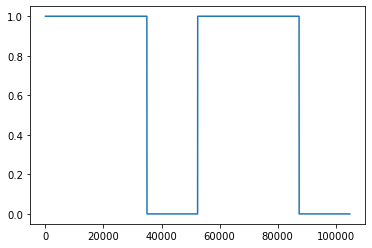

In [ ]:
import matplotlib.pyplot as plt
from nixtla.data.datasets.epf import EPF, EPFInfo

args = pd.Series({'dataset': ['NP']})

Y_df, X_df, S_df = EPF.load_groups(directory='../data', groups=['NP', 'PJM'])

mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=728*24, is_test=False)

plt.plot(mask_df.sample_mask.values)

In [ ]:
dataset = TimeSeriesDataset(Y_df=Y_df, S_df=S_df, X_df=X_df, mask_df=mask_df, verbose=True)

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
PJM       0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
INFO:root:
Total data 			104832 time stamps 
Available percentage=100.0, 	104832 time stamps 
Insample  percentage=66.67, 	69888.0 time stamps 
Outsample percentage=33.33, 	34944.0 time stamps 



In [ ]:
print(dataset.ts_tensor[0, dataset.t_cols.index('y'), :])

[31.05 30.47 28.92 ... 49.09 49.02 48.1 ]


In [ ]:
print("dataset.ts_tensor.shape", dataset.ts_tensor.shape)

dataset.ts_tensor.shape (2, 13, 52416)


In [ ]:
filtered, right_padding = dataset.get_filtered_ts_tensor(output_size=12, window_sampling_limit=36)

In [ ]:
from nixtla.data.datasets.tourism import Tourism, TourismInfo
print(TourismInfo.groups[0])
Y_df, *_ = Tourism.load(directory='../data', group=TourismInfo.groups[0])

train_ts_dataset = TimeSeriesDataset(Y_df=Y_df, ds_in_test=6)

Yearly


In [ ]:
from nixtla.data.datasets.m4 import M4, M4Info

Y_df, *_ = M4.load(directory='../data', group=M4Info.groups[0])

train_ts_dataset = TimeSeriesDataset(Y_df=Y_df, ds_in_test=6, verbose=True)

INFO:root:Train Validation splits

INFO:root:             ds     
            min  max
sample_mask         
0.0          14  841
1.0           1  835
INFO:root:
Total data 			858458 time stamps 
Available percentage=100.0, 	858458 time stamps 
Insample  percentage=83.92, 	720458.0 time stamps 
Outsample percentage=16.08, 	138000.0 time stamps 

